## Install Packages

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install facenet-pytorch

In [3]:
# requirements_file_path = "/content/drive/MyDrive/Masters/Prep/Projects/OneShot_JPMC/one-shot-face-recognition/src/requirements.txt"

# !cat "/content/drive/MyDrive/Masters/Prep/Projects/OneShot_JPMC/one-shot-face-recognition/src/requirements.txt" | xargs -n 1 pip install

In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import zipfile 
import torch
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score
import src
from tqdm.notebook import tqdm
from src.utils.celeba_helper import CelebADataset, CelebAClassifier, save_file_names, CelebADatasetTriplet
from src.utils.loss_functions import TripletLoss
from imp import reload

workers = 0 if os.name == 'nt' else 2

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define CelebA Dataset and Loader

In [6]:
## Load the dataset
# Path to directory with all the images
img_folder = 'data/img_align_celeba'
mapping_file = 'data/identity_CelebA_train_test_split.txt'

# Spatial size of training images, images are resized to this size.
image_size = 160
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADatasetTriplet(img_folder, mapping_file, transform)

Image names size is: 202599


In [7]:
len(celeba_dataset.test_df)

192422

In [8]:
## Create a dataloader
# Batch size during training
batch_size = 8
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,  # type: ignore
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

# FaceNet Training Pipeline

## Initializing the resnet model, optimizer and loss function

In [9]:
resnet = InceptionResnetV1(pretrained='vggface2').to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
criterion = TripletLoss()

## Test before training

In [10]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]

test_anchor_emb = resnet(test_anchor[None, :])
test_pos_emb = resnet(test_pos[None, :])
test_neg_emb = resnet(test_neg[None, :])

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

The distance between anchor and positive: 0.9184950590133667
The distance between anchor and negative: 1.6955020427703857


## Training steps

In [11]:
resnet.train()
epochs = 5
loss_total = []

for epoch in tqdm(range(epochs), desc="Epochs", leave=True, ncols=80, position=0):
    running_loss = []
    for step, (anchors, positives, negatives, labels) in enumerate(tqdm(celeba_dataloader, desc="Training", ncols=80, position=1, leave=False)):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)

        optimizer.zero_grad()

        anchor_emb = resnet(anchors)
        positive_emb = resnet(positives)
        negative_emb = resnet(negatives)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        # print("loss is {}".format(loss))
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
        
    loss_total.append(np.mean(running_loss))
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch, epochs, np.mean(running_loss)))


Epochs:   0%|                                             | 0/5 [00:00<?, ?it/s]

Training:   0%|                                        | 0/1273 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plotting Loss curve

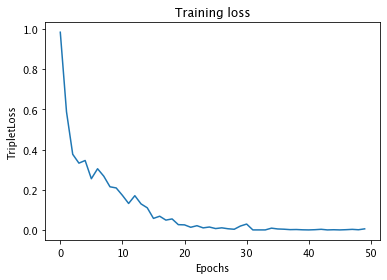

In [11]:
# printing loss function
plt.plot(loss_total)
plt.xlabel("Epochs")
plt.ylabel("TripletLoss")
plt.title("Training loss")
plt.show()

## Testing the trained model:

In [12]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]

test_anchor_emb = resnet(test_anchor[None, :])
test_pos_emb = resnet(test_pos[None, :])
test_neg_emb = resnet(test_neg[None, :])

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

The distance between anchor and positive: 0.939580500125885
The distance between anchor and negative: 0.6248536705970764


In [13]:
test_anchor_emb.shape

torch.Size([1, 512])

## Accuracy of the model

In [14]:
vault_path = "../data/oneshot_vault"
label_file = "../data/identity_vault_person.txt"

def load_image(path, transform):
    img = Image.open(path).convert("RGB")
    if transform:
            img = transform(img)
    return img
    
def create_embeddings(folder, label_file, model, transform):
    label_file_dict = {}
    gt_labels = []
    with open(label_file, 'r') as r_file:
        for file in r_file:
            file = file.strip("\n").split(" ")
            if file[0] not in label_file_dict:
                label_file_dict[file[0]] = file[1]

    embeddings = torch.empty(len(label_file_dict), 512)
    for i, file in enumerate(label_file_dict.keys()):
        img = load_image(os.path.join(folder, file), transform)

        img_emb = model(img[None, :])

        embeddings[i] = img_emb
        gt_labels.append(label_file_dict[file])

    return embeddings, gt_labels


transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])
embeddings, gt_labels = create_embeddings(folder=vault_path, label_file=label_file, 
                        model=resnet, transform=transform)
                        

In [15]:
# Test image:
def calculate_label(test_image_file, img_folder, transform, embeddings):
# test_image_file = "s1_9.pgm"
    test_file_path = os.path.join(img_folder, test_image_file)
    test_img = load_image(test_file_path, transform=transform)


    test_img_emb = resnet(test_img[None, :])
    test_img_emb = torch.squeeze(test_img_emb, 0)
    # print(f'Shape of test: {test_img_emb.shape}')
    # print(f'Shape of embeddings: {embeddings.shape}')

    distance_mat = (test_img_emb - embeddings).pow(2).sum(axis=1)
    # print(distance_mat)
    test_label_pred = gt_labels[torch.argmin(distance_mat.abs())]
    # print(f'Ground truth label: {test_image_file.split("_")[0][1]}')
    # print(f'Predicted label: {test_label_pred}')

    return int(test_label_pred)

# testing on one test image
test_image_file = "s4_9.pgm"
calculate_label(test_image_file, img_folder, transform, embeddings)


4

In [16]:

with open(mapping_file, 'r') as test_labels_file:
    test_labels = {}
    for file in test_labels_file:
        file = file.strip("\n").split(" ")
        test_labels[file[0]] = file[1]

test_predictions = []
test_gt_labels = []

for i, (file, label) in enumerate(test_labels.items()):
    test_gt_labels.append(int(label))

    test_label_pred = calculate_label(file, img_folder, transform, embeddings)
    test_predictions.append(test_label_pred)

accuracy = torch.tensor(test_predictions) == torch.tensor(test_gt_labels)
accuracy = accuracy.int().sum()/len(accuracy)
print(f'Accuracy for the model: {accuracy}')



Accuracy for the model: 0.6399999856948853
